In [1]:

!pip3 install torch torchvision
!pip3 install accelerate
!pip3 install transformers[torch]
!pip3 install accelerate -U
import pandas as pd
import json
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import numpy as np
import matplotlib.pyplot as plt
from sklearn import naive_bayes
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import RandomOverSampler

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score
import transformers
from transformers import BertModel, BertTokenizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip freeze > requirements.txt



  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dfr = pd.read_json("/content/drive/My Drive/yelp_academic_dataset_review.json", lines=True, orient='columns', nrows=15000)
dfr

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
145,pJRn59F_lyNO1zT3TCVd0Q,TGgfqWnUaCf6DM7TLuNhDQ,pSmOH4a3HNNpYM82J5ycLA,3,0,0,0,"This is a pretty good pancake place, but it's ...",2018-03-04 00:07:27
146,WSeO-PP8yxmUs8ts2myRzA,W7c1eS1WpxGC5295iJpuTQ,RfkaKLn494TKC943fJhKOw,5,1,0,0,Great finds and wonderful staff! \nLOVE our fi...,2013-09-04 14:41:57
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04
148,HME_ksGph3se7Aze5hxa-Q,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,0,0,1,Dine-in gets 2 stars. Disappointing service & ...,2014-07-13 17:25:47


In [4]:
def map_stars_to_sentiment(star_rating):
    if star_rating in [1, 2]:
        return 1  # Negative sentiment
    elif star_rating == 3:
        return 2  # Neutral sentiment
    elif star_rating in [4, 5]:
        return 3  # Positive sentiment

# Apply this function to the 'stars' column to create a new 'sentiment' column
dfr['sentiment'] = dfr['stars'].apply(map_stars_to_sentiment)

# Display the updated DataFrame
dfr

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,3
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,3
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,3
...,...,...,...,...,...,...,...,...,...,...
145,pJRn59F_lyNO1zT3TCVd0Q,TGgfqWnUaCf6DM7TLuNhDQ,pSmOH4a3HNNpYM82J5ycLA,3,0,0,0,"This is a pretty good pancake place, but it's ...",2018-03-04 00:07:27,2
146,WSeO-PP8yxmUs8ts2myRzA,W7c1eS1WpxGC5295iJpuTQ,RfkaKLn494TKC943fJhKOw,5,1,0,0,Great finds and wonderful staff! \nLOVE our fi...,2013-09-04 14:41:57,3
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,3
148,HME_ksGph3se7Aze5hxa-Q,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,0,0,1,Dine-in gets 2 stars. Disappointing service & ...,2014-07-13 17:25:47,1


In [5]:
dfr.columns

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date', 'sentiment'],
      dtype='object')

In [6]:
# Load restaurant business IDs from the file
with open('/content/drive/My Drive/restaurant_business_ids.txt') as f:
    restaurant_ids = f.read().splitlines()

# Filter reviews based on restaurant business IDs
rdf = dfr[dfr['business_id'].isin(restaurant_ids)]

# Save the filtered reviews to a new file
rdf.to_csv('restaurant_reviews.csv', index=False)

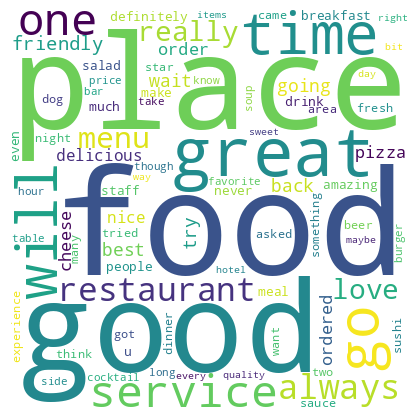

In [7]:
from wordcloud import WordCloud
from os import path
from PIL import Image
def wordCloud_generator(data, title=None):
    wordcloud = WordCloud(width = 400, height = 400,
                          background_color ='white',
                          min_font_size = 10
                         ).generate(" ".join(data.values))
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title,fontsize=30)
    plt.show()
wordCloud_generator(rdf['text'], title="")

In [8]:
freq_top = pd.Series(' '.join(rdf['text']).split()).value_counts()[:10]
freq_top

the    333
and    302
a      210
to     203
I      194
was    160
of     130
is     117
for    109
The     85
Name: count, dtype: int64

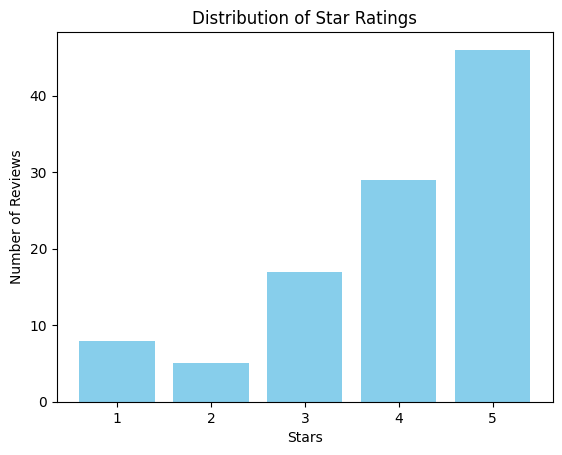

In [9]:
star_counts = rdf['stars'].value_counts().sort_index()

# Plot the histogram
plt.bar(star_counts.index, star_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Star Ratings')

# Show plot
plt.show()

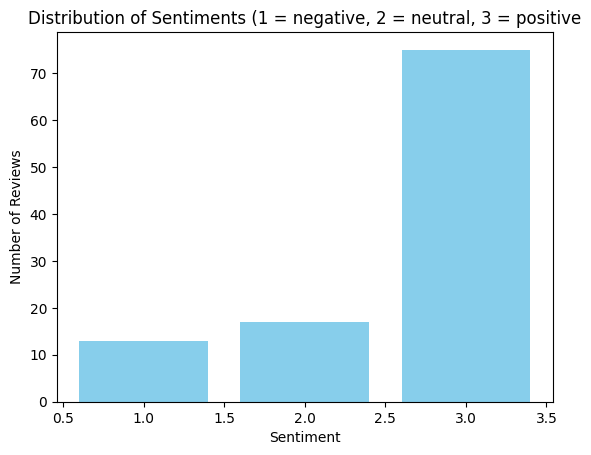

In [10]:
sentiment_counts = rdf['sentiment'].value_counts().sort_index()

# Plot the histogram
plt.bar(sentiment_counts.index, sentiment_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Sentiments (1 = negative, 2 = neutral, 3 = positive')

# Show plot
plt.show()

In [11]:
rdf

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,2
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,2
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,3
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,3
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,1
...,...,...,...,...,...,...,...,...,...,...
144,k7HWRysS3ICXxzhbddCemw,Vn8iqqu3T8QkmOlyH82zDA,a1u9Bxrq_fZxl2pgqQUcJA,4,0,0,0,It's was okay service was a bit on the interes...,2018-07-17 00:10:34,3
145,pJRn59F_lyNO1zT3TCVd0Q,TGgfqWnUaCf6DM7TLuNhDQ,pSmOH4a3HNNpYM82J5ycLA,3,0,0,0,"This is a pretty good pancake place, but it's ...",2018-03-04 00:07:27,2
147,ypFqmURIY41F4pWaMW1VrQ,hToW2eoTAYlOcuNz7I73Cg,7L1kXfwU5XM6f6Jxo_L7Yg,5,1,0,0,We've been coming here since I was a kid. The ...,2015-07-03 22:36:04,3
148,HME_ksGph3se7Aze5hxa-Q,kSMOJwJXuEUqzfmuFncK4A,kxX2SOes4o-D3ZQBkiMRfA,2,0,0,1,Dine-in gets 2 stars. Disappointing service & ...,2014-07-13 17:25:47,1


<ipython-input-12-a5ac0587b1df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['text_length'] = rdf['text'].apply(len)


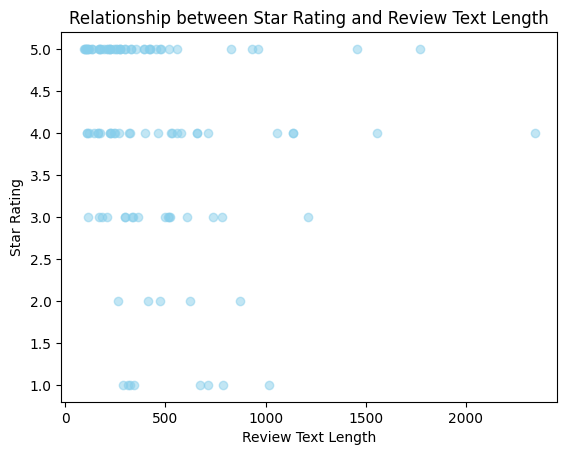

In [12]:

# Add a column for text length
rdf['text_length'] = rdf['text'].apply(len)

# Plot the relationship between star rating and text length
plt.scatter(rdf['text_length'], rdf['stars'], color='skyblue', alpha=0.5)

# Add labels and title
plt.xlabel('Review Text Length')
plt.ylabel('Star Rating')
plt.title('Relationship between Star Rating and Review Text Length')

# Show plot
plt.show()

In [13]:
punctuation_marks = [',', '.', '!', '?', ';', ':', '-', '"', "'", '(', ')', '[', ']', '{', '}', '\n']
rdf['text'] = rdf['text'].str.lower()
for mark in punctuation_marks:
    rdf['text'] = rdf['text'].str.replace(mark, "")
rdf.head()

<ipython-input-13-ff1339cf4b3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['text'] = rdf['text'].str.lower()
<ipython-input-13-ff1339cf4b3a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['text'] = rdf['text'].str.replace(mark, "")


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,if you decide to eat here just be aware it is ...,2018-07-07 22:09:11,2,513
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,family diner had the buffet eclectic assortmen...,2014-02-05 20:30:30,2,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,wow yummy different delicious our favorite...,2015-01-04 00:01:03,3,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,cute interior and owner gave us tour of upcom...,2017-01-14 20:54:15,3,534
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,i am a long term frequent customer of this est...,2015-09-23 23:10:31,1,341


In [14]:
rdf['text'].head()

0    if you decide to eat here just be aware it is ...
2    family diner had the buffet eclectic assortmen...
3    wow  yummy different  delicious   our favorite...
4    cute interior and owner  gave us tour of upcom...
5    i am a long term frequent customer of this est...
Name: text, dtype: object

In [15]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Bag of Words Text Processing with TF-IDF and CountVectorizer

In [16]:
## Initialize TF-IDF Vectorizer with ngram_range=(1,2), which tells vectorizer to include unigrams and bigrams
stopwords_list = list(stopwords.words('english'))



In [17]:
## Show most top 10 most frequently occurring words
freq_top = pd.Series(' '.join(rdf['text']).split()).value_counts()[:10]
freq_top

the    412
and    311
a      219
to     207
i      197
was    161
of     131
is     119
for    115
it     107
Name: count, dtype: int64

In [18]:

from nltk.stem import PorterStemmer


# Download NLTK resources (if not already downloaded)
nltk.download('punkt')

# Initialize the Porter Stemmer
porter_stemmer = PorterStemmer()

def stem_words(words):
    # Stem each word using the Porter Stemmer
    stemmed_words = [porter_stemmer.stem(word) for word in words.split()]
    words = ''.join(porter_stemmer.stem(word) for word in words)
    return words

# Apply the stem_words function to each list of words in the 'text' column
rdf['text'] = rdf['text'].apply(stem_words)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-18-f484c0bd83f1>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rdf['text'] = rdf['text'].apply(stem_words)


In [19]:

rdf.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment,text_length
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,if you decide to eat here just be aware it is ...,2018-07-07 22:09:11,2,513
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,family diner had the buffet eclectic assortmen...,2014-02-05 20:30:30,2,339
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,wow yummy different delicious our favorite...,2015-01-04 00:01:03,3,243
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,cute interior and owner gave us tour of upcom...,2017-01-14 20:54:15,3,534
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,i am a long term frequent customer of this est...,2015-09-23 23:10:31,1,341


In [20]:
X_train, X_test, y_train, y_test = train_test_split(rdf['text'], rdf['sentiment'], test_size=0.2, random_state=42)

## Multinomial Naive Bayes

In [21]:
# Analyze data using TF-IDF vectorizer and CountVectorizer
tfidf_vectorizer = TfidfVectorizer(use_idf=True, lowercase=True, strip_accents='ascii', stop_words=stopwords_list, ngram_range=(1, 2))
count_vectorizer = CountVectorizer(max_features=5000, stop_words=stopwords.words('english'), ngram_range=(1,2))

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

In [22]:
ros = RandomOverSampler(random_state=42)
X_train_tfidf_resampled, y_train_resampled_tfidf = ros.fit_resample(X_train_tfidf, y_train)
X_train_count_resampled, y_train_resampled_count = ros.fit_resample(X_train_count, y_train)

In [23]:
sentiment_counts = y_train_resampled_tfidf.value_counts()

print("Number of reviews for each sentiment rating:")
for sentiment, count in sentiment_counts.items():
    print(f"{sentiment} sentiment rating: {count}")

Number of reviews for each sentiment rating:
3 sentiment rating: 62
1 sentiment rating: 62
2 sentiment rating: 62


In [24]:
mnb_tfidf = MultinomialNB()
mnb_tfidf.fit(X_train_tfidf_resampled, y_train_resampled_tfidf)

mnb_count = MultinomialNB()
mnb_count.fit(X_train_count_resampled, y_train_resampled_count)


MultinomialNB()

In [25]:
y_pred_tfidf = mnb_tfidf.predict(X_test_tfidf)
y_pred_count = mnb_count.predict(X_test_count)

print("Naive Bayes Classification Report with TF-IDF Vectorizer:\n", classification_report(y_test, y_pred_tfidf))

print("Naive Bayes Classification Report with Count Vectorizer:\n", classification_report(y_test, y_pred_count))

Naive Bayes Classification Report with TF-IDF Vectorizer:
               precision    recall  f1-score   support

           1       0.20      0.33      0.25         3
           2       1.00      0.40      0.57         5
           3       0.79      0.85      0.81        13

    accuracy                           0.67        21
   macro avg       0.66      0.53      0.55        21
weighted avg       0.75      0.67      0.68        21

Naive Bayes Classification Report with Count Vectorizer:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       1.00      0.20      0.33         5
           3       0.68      1.00      0.81        13

    accuracy                           0.67        21
   macro avg       0.56      0.40      0.38        21
weighted avg       0.66      0.67      0.58        21



## Deep Learning Model - DistilBERT



In [26]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    rdf['text'], rdf['sentiment'], test_size=0.2, random_state=42
)

In [27]:
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    np.array(train_texts).reshape(-1, 1), np.array(train_labels).reshape(-1, 1)
)
train_texts_resampled = train_texts_resampled.flatten()

In [29]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts_resampled.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [30]:
import torch

class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx] - 1)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = YelpDataset(train_encodings, train_labels_resampled.ravel())
val_dataset = YelpDataset(val_encodings, val_labels.to_numpy())

In [31]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Generate a classification report
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",     # Evaluate at the end of each epoch
    save_strategy="epoch",           # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True      # Load the best model at the end of training
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model and capture the output
train_output = trainer.train()

# Evaluate the model to get the computed metrics during evaluation
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.106700,1.091743,0.428571,0.348214,0.428571,0.384236
2,1.089400,1.109786,0.190476,0.377551,0.190476,0.163772
3,1.041100,1.113988,0.285714,0.406349,0.285714,0.273109


Evaluation Results: {'eval_loss': 1.0917433500289917, 'eval_accuracy': 0.42857142857142855, 'eval_precision': 0.3482142857142857, 'eval_recall': 0.42857142857142855, 'eval_f1': 0.3842364532019704, 'eval_runtime': 0.1494, 'eval_samples_per_second': 140.558, 'eval_steps_per_second': 13.386, 'epoch': 3.0}


In [32]:
print(f"Accuracy: {eval_results['eval_accuracy']*100:.4f}")
print(f"Precision: {eval_results['eval_precision']*100:.4f}")
print(f"Recall: {eval_results['eval_recall']*100:.4f}")
print(f"F1 Score: {eval_results['eval_f1']*100:.4f}")

Accuracy: 42.8571
Precision: 34.8214
Recall: 42.8571
F1 Score: 38.4236


## Deep Learning Model - BERT

In [33]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    rdf['text'], rdf['sentiment'], test_size=0.2, random_state=42
)

In [34]:
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    np.array(train_texts).reshape(-1, 1), np.array(train_labels).reshape(-1, 1)
)
train_texts_resampled = train_texts_resampled.flatten()

In [35]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts_resampled.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [36]:
import torch

class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx] - 1)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = YelpDataset(train_encodings, train_labels_resampled.ravel())
val_dataset = YelpDataset(val_encodings, val_labels.to_numpy())


In [37]:
# BERT code adapted from Huggingface Transformers library
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Generate a classification report
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# Evaluate the model to get the computed metrics during evaluation
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.113400,1.166386,0.142857,0.256548,0.142857,0.152604
2,1.024200,1.089729,0.428571,0.409524,0.428571,0.413265
3,0.830200,1.027503,0.619048,0.555556,0.619048,0.585034


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results: {'eval_loss': 1.0275026559829712, 'eval_accuracy': 0.6190476190476191, 'eval_precision': 0.5555555555555556, 'eval_recall': 0.6190476190476191, 'eval_f1': 0.5850340136054422, 'eval_runtime': 0.2436, 'eval_samples_per_second': 86.213, 'eval_steps_per_second': 8.211, 'epoch': 3.0}


In [38]:
print(f"Accuracy: {eval_results['eval_accuracy']*100:.4f}")
print(f"Precision: {eval_results['eval_precision']*100:.4f}")
print(f"Recall: {eval_results['eval_recall']*100:.4f}")
print(f"F1 Score: {eval_results['eval_f1']*100:.4f}")

Accuracy: 61.9048
Precision: 55.5556
Recall: 61.9048
F1 Score: 58.5034


## Deep Learning Model - RoBERTa

In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    rdf['text'], rdf['sentiment'], test_size=0.2, random_state=42
)

In [ ]:
ros = RandomOverSampler(random_state=42)
train_texts_resampled, train_labels_resampled = ros.fit_resample(
    np.array(train_texts).reshape(-1, 1), np.array(train_labels).reshape(-1, 1)
)
train_texts_resampled = train_texts_resampled.flatten()

In [ ]:
from transformers import RobertaTokenizer

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_texts_resampled.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
class YelpDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx] - 1)  # adjust labels to start from 0
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = YelpDataset(train_encodings, train_labels_resampled.ravel())
val_dataset = YelpDataset(val_encodings, val_labels.to_numpy())

In [ ]:
# Load RoBERTa with a classification head
from transformers import RobertaForSequenceClassification, Trainer, TrainingArguments
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=3)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Generate a classification report
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
# Training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=8,   # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    evaluation_strategy="epoch",  # Evaluate at the end of each epoch
    save_strategy="epoch",  # Save model checkpoint at the end of each epoch
    load_best_model_at_end=True
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()
# Evaluate the model to get the computed metrics during evaluation
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.101100,1.100829,0.238095,0.056689,0.238095,0.091575
2,1.093900,1.110486,0.238095,0.056689,0.238095,0.091575
3,1.077000,1.121976,0.285714,0.710919,0.285714,0.217687


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation Results: {'eval_loss': 1.1008291244506836, 'eval_accuracy': 0.23809523809523808, 'eval_precision': 0.05668934240362812, 'eval_recall': 0.23809523809523808, 'eval_f1': 0.09157509157509157, 'eval_runtime': 0.2855, 'eval_samples_per_second': 73.561, 'eval_steps_per_second': 7.006, 'epoch': 3.0}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(f"Accuracy: {eval_results['eval_accuracy']*100:.4f}")
print(f"Precision: {eval_results['eval_precision']*100:.4f}")
print(f"Recall: {eval_results['eval_recall']*100:.4f}")
print(f"F1 Score: {eval_results['eval_f1']*100:.4f}")


Accuracy: 23.8095
Precision: 5.6689
Recall: 23.8095
F1 Score: 9.1575


In [ ]:
!pip freeze > requirements.txt
